---
title: "Z变换改造均线，一个12年前的策略为何仍能跑赢大盘？"
slug: low-latency-trend-line
date: 2025-07-16
category: strategy
motto: 兰生幽谷，不为莫服而不芳
img: https://cdn.jsdelivr.net/gh/zillionare/images@main/images/2025/07/neom-tSwRu3Jh0EM-unsplash.jpg
tags: 
    - strategy
    - 因子
    - LLT
---

传统移动平均线（MA）是技术分析中常用的趋势跟踪指标，通过对股票价格或指数在一定天数内的平均值进行计算，以刻画其变动方向。MA 的计算天数越多，其平滑性越好，但随之而来的时滞（延迟）影响也越严重。这意味着 MA 指标在跟踪趋势时容易出现“跟不紧”甚至“跟不上”的情况，平滑性和延迟性成为其不可避免的矛盾。

低延迟趋势线（LLT）的构造借鉴了信号处理理论中的滤波方法。传统的 EMA 指标被视为一阶低通滤波器，但其滤波效果相对较差，通带和阻带间的过渡带太长。LLT 通过设计二阶滤波器来优化滤波效果，实现了对信号高频部分的有效过滤，同时保留了低频部分的强度。与 MA 和 EMA 均线相比，LLT 大幅降低了延迟，同时兼顾了趋势线的平滑性，从而克服了传统 MA 指标在跟踪趋势时的滞后问题。

本文取材于广发证券-《低延迟趋势线与交易择时》一文。原文仅回测到2013年。我们在此基础上回测到2024年底，发现它在多空组合时，仍有很好的表现（上证夏普1.33）。

```` {tip} 策略档案之LLT
| LLT               | Benchmark  | Strategy   |
| ----------------- | ---------- | ---------- |
| Start Period      | 2013-01-04 | 2013-01-04 |
| End Period        | 2024-12-31 | 2024-12-31 |
| Cumulative Return | 47%        | 345%       |
| CAGR﹪             | 2%         | 9%         |
| Sharpe            | 0.27       | 1.33       |
````


## 传统均线系统

为了对比，我们先给出传统均线的定义及图形。

移动平均（Moving Average）线，其算法为：

$MA(n) = \frac{1}{n}\sum^{n-1}_{i=0}price(T-i)$

其中 price 一般选择收盘价，MA(n) 即为 T 日的 n 日均线指标。对于 MA 指标，n 越大，趋势线的平滑性越好。

基于移动均线，我们可以实现一个简单的趋势跟随策略。信号的判断方式是看移动平均线的切线。如果切线斜率向上，则多头持有；如果切线斜率向下，则多头卖出。

下面的代码演示了 5, 10, 30 和 60 日均线。其中 30 日均线被称为生命线。最后的绘图中，显示了 30 日均线上，切线由正转负的情况。

In [1]:
def get_price(symbol, start_date, end_date):
    pro = pro_api()

    price_df = pro.index_daily(
        ts_code=symbol,
        start_date=start_date.strftime("%Y%m%d"),
        end_date=end_date.strftime("%Y%m%d"),
    )

    price_df = (
        price_df.rename({"trade_date": "date", "ts_code": "asset"}, axis=1)
        .sort_values("date", ascending=True)
        .set_index("date")
    )

    return price_df


在该图中，绿色线为30日线。红点处，30日均线斜率由正转负，即为卖出信号。我们看到，通过 30 日均线的趋势跟随，可以捕捉到大的波段行情。但是，当趋势线提示我们该下车时，已经离行情高点下降不少。但如果使用 5 日均线这种短一点的均线，又会导致频繁发出信号，增加交易成本的情况。

这个结果表明，传统均线存在窗口小时，均线不平滑，趋势线切线上下抖动现象严重；窗口大时，均线平滑性好，但滞后性较强的问题。

```` {tip}
寻找切线反转点（即切线斜率由正变负，或者由负变正）时，比较有技巧。这个技巧在很多场合下都会遇到：
```python
price_df["slope_30_5"] = price_df["slope_30_5"].fillna(0)
signs = np.sign(price_df["slope_30_5"])
sign_changes = signs * signs.shift(1) == -1

revert_dates = price_df.index[sign_changes]
```
````


如何解决传统均线在延迟和平滑上，存在鱼与熊掌不可兼得的矛盾？

## LLT 均线

研报在 LLT 均线的原理及推导上介绍得比较深入细致。但是，要理解 LLT，需要有 Z 变换等基础，我们简单解释如下：

$$\frac{LLT(z)}{price(z)} = \frac{(\alpha-\alpha^2/4) + (\alpha^2/2)z^{-1} - (\alpha-3\alpha^2/4)z^{-2}}{1-2(1-\alpha)z^{-1} + (1-\alpha)^2z^{-2}}$$

这是一个所谓的Z域上的公式，我们需要按相应的规则，变换为时域公式。它的变换规则是：


- 上式是一个二阶 IIR 滤波器的传递函数。要得到时域递推公式，需要将分子分母都乘以分母的表达式，使分母变为 1（即左边只剩 LLT(z)），右边是分子的多项式与 price(z) 的卷积：
    $$LLT(z) \cdot [1-2(1-\alpha)z^{-1} + (1-\alpha)^2z^{-2}] = price(z) \cdot [(\alpha-\alpha^2/4) + (\alpha^2/2)z^{-1} - (\alpha-3\alpha^2/4)z^{-2}]$$
- 展开后，按 z 变换的性质，将 z^{-1}、z^{-2}分别对应到时域的 t-1、t-2 期：
    $$LLT_t - 2(1-\alpha)LLT_{t-1} + (1-\alpha)^2LLT_{t-2} = (\alpha-\alpha^2/4)price_t + (\alpha^2/2)price_{t-1} - (\alpha-3\alpha^2/4)price_{t-2}$$
- 移项得到递推公式：
    $$LLT_t = (\alpha-\alpha^2/4)price_t + (\alpha^2/2)price_{t-1} - (\alpha-3\alpha^2/4)price_{t-2} + 2(1-\alpha)LLT_{t-1} - (1-\alpha)^2LLT_{t-2}$$

变换后，我们最终得到的公式为：

$$
y_t = (\alpha-\alpha^2/4)x_t + (\alpha^2/2)x_{t-1} - (\alpha-3\alpha^2/4)x_{t-2} + 2(1-\alpha)y_{t-1} - (1-\alpha)^2y_{t-2}
$$

可以看到，最终公式是一个递归函数，这里的$y_t$即为我们要求的LLT，它由前两期的LLT与最近三期的价格、以及一个$\alpha$参数共同决定。




它的实现代码是：

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def calculate_llt(prices, alpha=0.05):
    """
    计算LLT (Linearly Weighted Least Squares Triangular) 均线

    参数:
    prices (array-like): 价格序列
    alpha (float): 平滑系数，范围(0,1)，值越小均线越平滑，滞后性越大

    返回:
    array: LLT均线序列
    """
    n = len(prices)
    llt = np.zeros(n)

    # 初始化前两个值
    if n >= 1:
        llt[0] = prices[0]
    if n >= 2:
        llt[1] = prices[1]

    # 计算系数
    a1 = alpha - (alpha**2) / 4
    a2 = (alpha**2) / 2
    a3 = alpha - 3 * (alpha**2) / 4
    a4 = 2 * (1 - alpha)
    a5 = -((1 - alpha) ** 2)

    # 递归计算LLT
    for t in range(2, n):
        llt[t] = (
            a1 * prices[t]
            + a2 * prices[t - 1]
            - a3 * prices[t - 2]
            + a4 * llt[t - 1]
            + a5 * llt[t - 2]
        )

    return llt


下面，我们对比一下EMA， 5日均线以及LLT均线：

## 回测与对比

我们先来看看传统均线的回测情况。我们将定义一个交易函数，它接受一个dataframe，因子列名和计算slope的窗口。后面我们在对LLT进行回测时，我们将使用同一个函数，这样可以确保对比的公正性。

我们在30日均线上，回测得到的结果，与研报基本一致，都在300%左右。

```` {tip}
理论上，知道回测时间，我们应该能做到像素级的复现。但是，这里有一个重要的参数，即求斜率时的窗口大小，研报没有披露。我们在复现时，使用的窗口为5。

````


所以，在对LLT进行回测时，我们只需要先计算出LLT，再将LLT作为因子传入 trading_strategy 函数即可。

In [6]:
def backtest(df, calc_signal, args, price: str = "open", long_weight: float = 0.5, short_weight: float = 0.5, long_short=True):
    """原始回测函数"""
    df = df.copy()
    df["signal"] = calc_signal(df, *args)
    df["signal"] = df["signal"].fillna(0)
    df["signal_shifted"] = df["signal"].shift(2)
    df["benchmark"] = df[price].pct_change()
    
    df['long_return'] = np.where(df['signal_shifted'] == 1, df['benchmark'], 0)
    df['short_return'] = np.where(df['signal_shifted'] == -1, -df['benchmark'], 0)
    df["long_short_return"] = df['long_return'] * long_weight + df['short_return'] * short_weight
    
    return df

def ma_slope_signal(df, window=30, slope_window=5):
    df = df.copy()
    ma = df["close"].rolling(window).mean()
    df['slope'] = (ma.rolling(slope_window)
                    .apply(lambda x: np.polyfit(np.arange(slope_window), x, 1)[0]))
    
    signals = pd.Series(0, index=df.index)
    signals[df['slope'] > 0] = 1
    signals[df['slope'] < 0] = -1
    
    return signals

def llt_slope_signal(df, d: int=30, slope_window=5):
    df = df.copy()
    alpha = 2 / (d + 1)
    df["llt"] = calculate_llt(df["close"], alpha)
    df['slope'] = (df["llt"].rolling(slope_window)
                    .apply(lambda x: np.polyfit(np.arange(slope_window), x, 1)[0]))
    
    signals = pd.Series(0, index=df.index)
    signals[df['slope'] > 0] = 1
    signals[df['slope'] < 0] = -1
    
    return signals

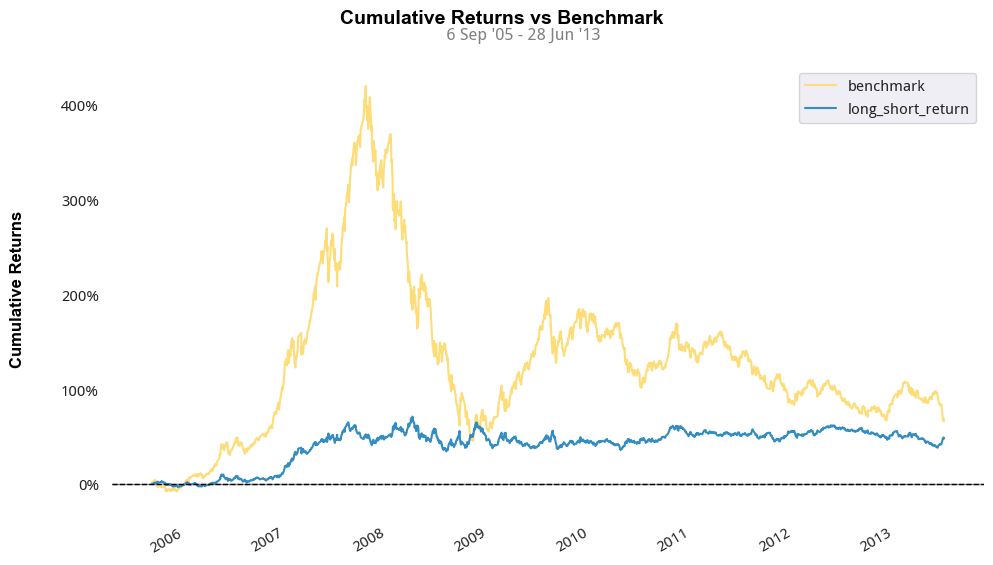

In [4]:
# cheat on close

start = datetime.date(2005, 9, 6)
end = datetime.date(2013, 6, 28)
prices= get_price("000001.SH", start, end)

# result_df = backtest(prices, ma_slope_signal, (30, 5), price="close")
result_df = backtest(prices, llt_slope_signal, (5, ), price="close")
result_df.index = pd.to_datetime(result_df.index)

qs.plots.returns(
    returns=result_df["long_short_return"],
    benchmark=result_df["benchmark"]
)

metrics = qs.reports.metrics(
        returns = result_df["long_short_return"],
        benchmark = result_df["benchmark"],
        display=False
    )


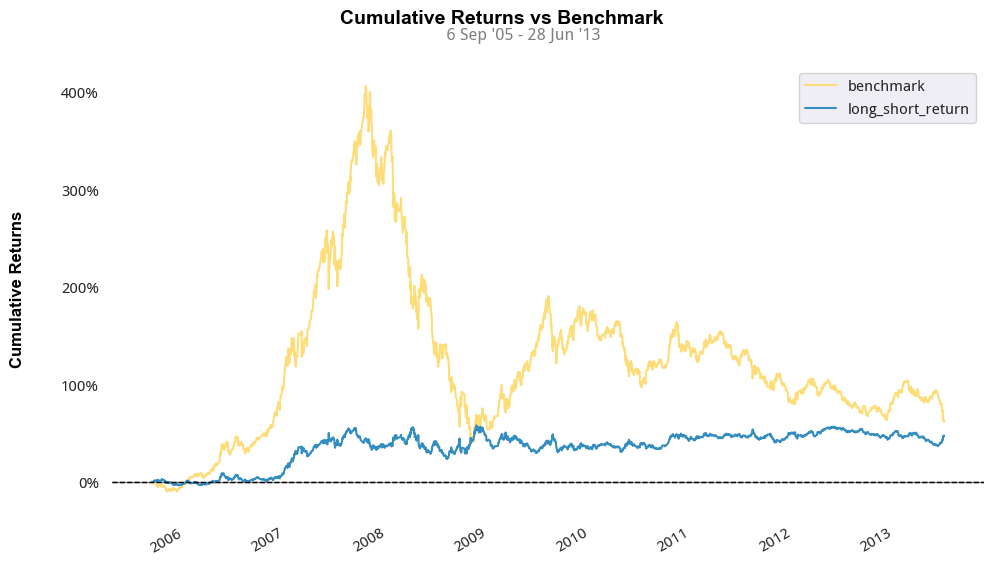

In [7]:
# cheat on close

start = datetime.date(2005, 9, 6)
end = datetime.date(2013, 6, 28)
prices= get_price("000001.SH", start, end)

# result_df = backtest(prices, ma_slope_signal, (30, 5), price="close")
result_df = backtest(prices, llt_slope_signal, (5, ), price="open")
result_df.index = pd.to_datetime(result_df.index)

qs.plots.returns(
    returns=result_df["long_short_return"],
    benchmark=result_df["benchmark"]
)

metrics = qs.reports.metrics(
        returns = result_df["long_short_return"],
        benchmark = result_df["benchmark"],
        display=False
    )


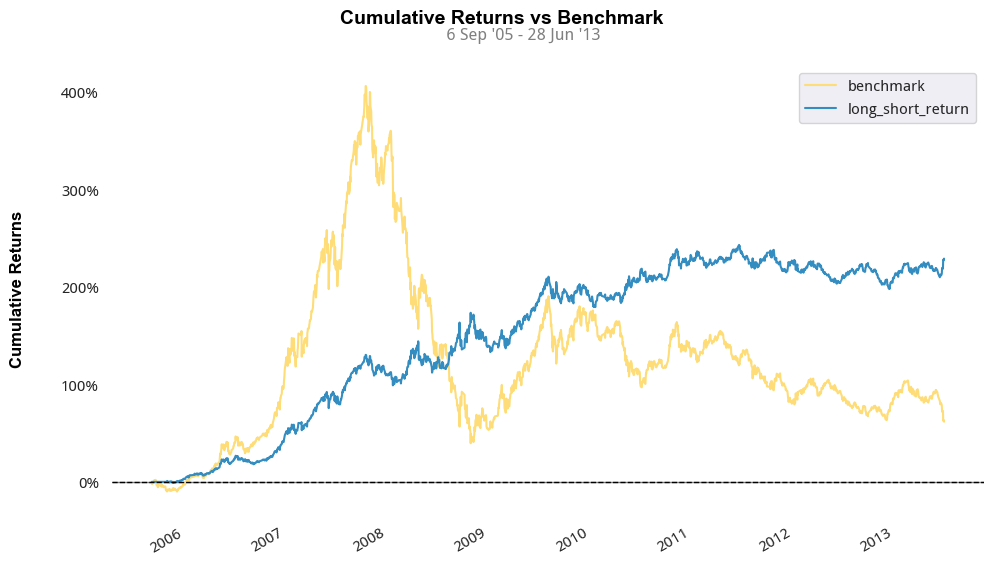

In [7]:
start = datetime.date(2005, 9, 6)
end = datetime.date(2013, 6, 28)
prices= get_price("000001.SH", start, end)

result_df = backtest(prices, ma_slope_signal, (30, 5))
result_df.index = pd.to_datetime(result_df.index)

qs.plots.returns(
    returns=result_df["long_short_return"],
    benchmark=result_df["benchmark"]
)

metrics = qs.reports.metrics(
        returns = result_df["long_short_return"],
        benchmark = result_df["benchmark"],
        display=False
    )



In [42]:
pd.options.display.max_rows = 300

start = datetime.date(2013, 1, 1)
end = datetime.date(2024, 12, 31)

prices= get_price("000001.SH", start, end)
# result_df = backtest(prices, llt_slope_signal, (5,))
# result_df["signal"].head(299)
prices.head(50)

,asset,close,open,high,low,pre_close,change,pct_chg,vol,amount
date,,,,,,,,,,
20130104,000001.SH,2276.992,2289.510,2296.113,2256.560,2269.128,7.864,0.3466,139469931.0,1.146278e+08
20130107,000001.SH,2285.364,2271.663,2293.317,2266.862,2276.992,8.372,0.3677,118162813.0,9.687287e+07
20130108,000001.SH,2276.070,2284.654,2289.139,2262.979,2285.364,-9.294,-0.4067,122907877.0,1.064288e+08
20130109,000001.SH,2275.340,2271.299,2283.896,2259.051,2276.070,-0.730,-0.0321,122014924.0,1.028231e+08
20130110,000001.SH,2283.658,2274.377,2295.484,2268.648,2275.340,8.318,0.3656,120066676.0,9.823640e+07
20130111,000001.SH,2242.997,2285.185,2290.205,2234.947,2283.658,-40.661,-1.7805,125068275.0,1.015510e+08
20130114,000001.SH,2311.740,2236.288,2317.617,2235.107,2242.997,68.743,3.0648,144749889.0,1.236149e+08
20130115,000001.SH,2325.682,2312.468,2332.783,2309.323,2311.740,13.942,0.6031,165645981.0,1.410140e+08
20130116,000001.SH,2309.499,2322.158,2326.764,2279.507,2325.682,-16.183,-0.6958,153511167.0,1.331077e+08


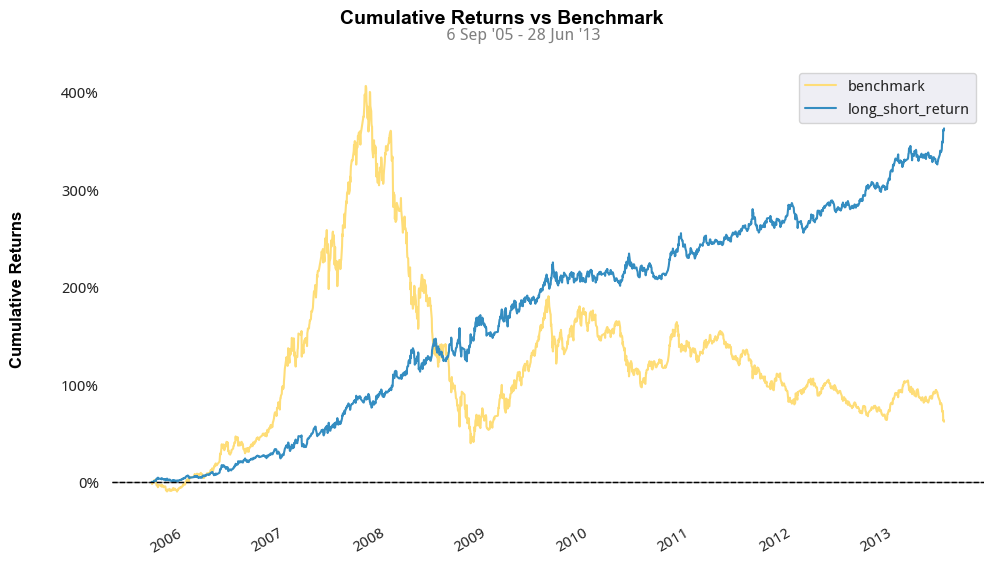

                     Benchmark    Strategy
Start Period        2005-09-06  2005-09-06
End Period          2013-06-28  2013-06-28
Risk-Free Rate               0           0
Time in Market             1.0         1.0
Cumulative Return         0.63        3.63
CAGR﹪                     0.04        0.14
Sharpe                    0.36        1.41
Prob. Sharpe Ratio        0.84         1.0
Sortino                   0.51        2.11
Sortino/√2                0.36        1.49


In [8]:
result_df = backtest(prices, llt_slope_signal, (5, ))
result_df.index = pd.to_datetime(result_df.index)

qs.plots.returns(
    returns=result_df["long_short_return"],
    benchmark=result_df["benchmark"]
)

metrics = qs.reports.metrics(
        returns = result_df["long_short_return"],
        benchmark = result_df["benchmark"],
        display=False
    )

print(metrics[:10])

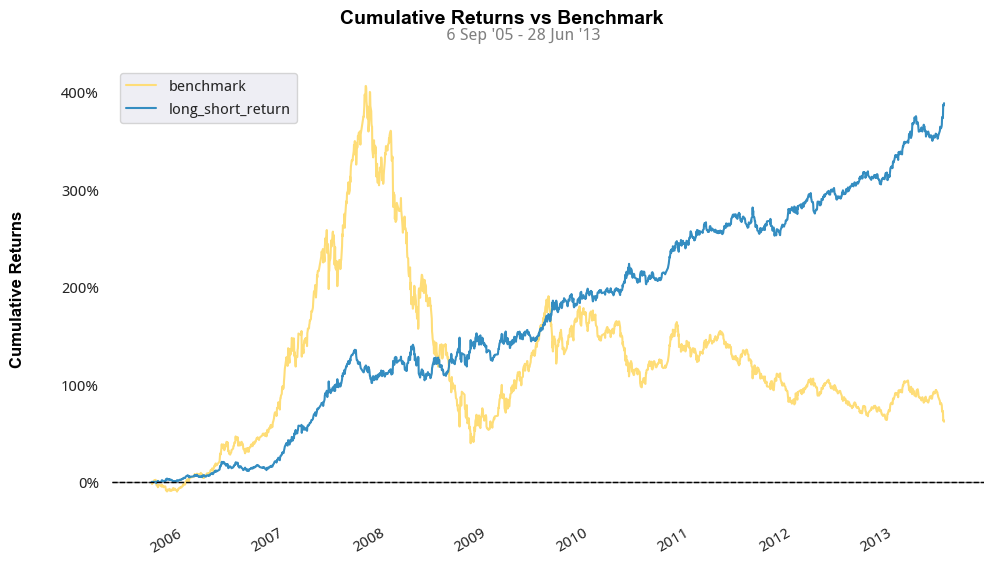

                     Benchmark    Strategy
Start Period        2005-09-06  2005-09-06
End Period          2013-06-28  2013-06-28
Risk-Free Rate               0           0
Time in Market             1.0         1.0
Cumulative Return         0.59        3.88
CAGR﹪                     0.04        0.15
Sharpe                    0.35        1.45
Prob. Sharpe Ratio        0.83         1.0
Sortino                    0.5        2.18
Sortino/√2                0.35        1.54


In [24]:
result_df = backtest(prices, ma_slope_signal, (5, ), price="open")
result_df.index = pd.to_datetime(result_df.index)

qs.plots.returns(
    returns=result_df["long_short_return"],
    benchmark=result_df["benchmark"]
)

metrics = qs.reports.metrics(
        returns = result_df["long_short_return"],
        benchmark = result_df["benchmark"],
        display=False
    )

print(metrics[:10])

In [51]:
import pandas as pd
import numpy as np

dates = pd.date_range('2023-01-01', periods=10, freq='D')

base_price = 100
growth_rate = np.array([0.05, -0.05] * int(len(dates)/2))

prices = np.array(base_price * np.cumprod((1 + growth_rate)))

df = pd.DataFrame({
    'open': prices,
}, index=dates)

print("价格数据:")
print(df[['open']].round(2))

价格数据:
              open
2023-01-01  105.00
2023-01-02   99.75
2023-01-03  104.74
2023-01-04   99.50
2023-01-05  104.48
2023-01-06   99.25
2023-01-07  104.21
2023-01-08   99.00
2023-01-09  103.95
2023-01-10   98.76


In [52]:
def simple_fixed_signal(df):
    """返回固定的信号序列，便于手工验证"""
    signals = pd.Series([
        0,   # 第1天：无信号
        1,   # 第2天：买入信号
        1,   # 第3天：持有
        0,   # 第4天：平仓
        -1,  # 第5天：卖出信号
        -1,  # 第6天：持有
        -1,   # 第7天：持有
        -1,   # 第8天：持有
        0,   # 第9天：平仓
        0    # 第10天：无信号
    ], index=df.index)
    
    return signals

In [53]:
result_df = backtest(df, simple_fixed_signal, ())
result_df

,open,signal,signal_shifted,benchmark,long_return,short_return,long_short_return
2023-01-01,105.000000,0,NaN,NaN,0.00,0.00,0.000
2023-01-02,99.750000,1,0.0,-0.05,0.00,0.00,0.000
2023-01-03,104.737500,1,1.0,0.05,0.05,0.00,0.025
2023-01-04,99.500625,0,1.0,-0.05,-0.05,0.00,-0.025
2023-01-05,104.475656,-1,0.0,0.05,0.00,0.00,0.000
2023-01-06,99.251873,-1,-1.0,-0.05,0.00,0.05,0.025
2023-01-07,104.214467,-1,-1.0,0.05,0.00,-0.05,-0.025
2023-01-08,99.003744,-1,-1.0,-0.05,0.00,0.05,0.025
2023-01-09,103.953931,0,-1.0,0.05,0.00,-0.05,-0.025
2023-01-10,98.756234,0,0.0,-0.05,0.00,0.00,0.000


In [56]:
start = datetime.date(2005, 9, 6)
end = datetime.date(2013, 6, 28)
prices= get_price("000001.SH", start, end)
result_df = run_backtrader_llt(prices, alpha=0.05, slope_window=5)
result_df

初始资金: 100000.00


AttributeError: module 'backtrader.indicators' has no attribute 'Slope'

找到的反转日期: ['20130312']


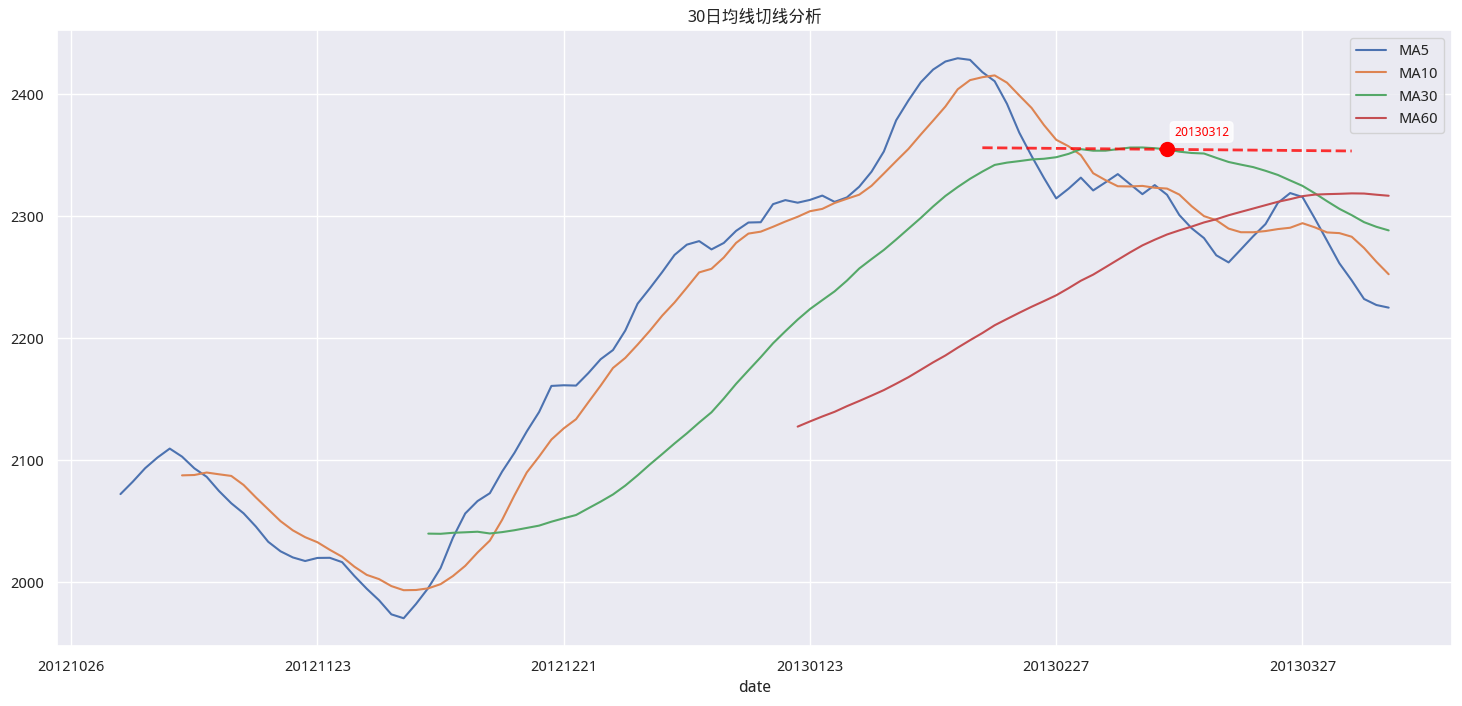

In [24]:
import backtrader as bt

def get_price(symbol, start_date, end_date):
    pro = pro_api()

    price_df = pro.index_daily(
        ts_code=symbol,
        start_date=start_date.strftime("%Y%m%d"),
        end_date=end_date.strftime("%Y%m%d"),
    )

    price_df = (
        price_df.rename({"trade_date": "date", "ts_code": "asset"}, axis=1)
        .sort_values("date", ascending=True)
        .set_index("date")
    )

    return price_df

def calculate_llt(prices, alpha=0.05):
    n = len(prices)
    llt = np.zeros(n)
    if n >= 1:
        llt[0] = prices[0]
    if n >= 2:
        llt[1] = prices[1]
    
    a1 = alpha - (alpha**2) / 4
    a2 = (alpha**2) / 2
    a3 = alpha - 3 * (alpha**2) / 4
    a4 = 2 * (1 - alpha)
    a5 = - (1 - alpha)**2
    
    for t in range(2, n):
        llt[t] = a1 * prices[t] + a2 * prices[t-1] - a3 * prices[t-2] + a4 * llt[t-1] + a5 * llt[t-2]
    
    return llt

# 您提供的信号计算函数
def llt_slope_signal(df, d: int=30, slope_window=5):
    df = df.copy()
    alpha = 2 / (d + 1)
    df["llt"] = calculate_llt(df["close"], alpha)
    df['slope'] = (df["llt"].rolling(slope_window)
                    .apply(lambda x: np.polyfit(np.arange(slope_window), x, 1)[0]))
    
    signals = pd.Series(0, index=df.index)
    signals[df['slope'] > 0] = 1
    signals[df['slope'] < 0] = -1
    
    return signals

class LongShortLLTStrategy(bt.Strategy):
    params = (
        ('d', 30),                # LLT参数d
        ('slope_window', 5),      # 斜率计算窗口
        ('long_weight', 0.5),     # 多头权重
        ('short_weight', 0.5),    # 空头权重
        ('volatility_period', 20) # 波动率计算周期
    )
    
    def __init__(self):
        # 预计算信号
        self.signals = llt_slope_signal(
            self.data._dataname,  # 访问原始DataFrame
            d=self.p.d,
            slope_window=self.p.slope_window
        )
        
        # 确保信号索引与回测日期对齐
        self.signals = self.signals.tz_localize(None)  # 移除时区信息
        
        # 计算波动率（用于仓位控制）
        self.volatility = bt.indicators.StdDev(
            self.data.close, 
            period=self.p.volatility_period
        )
        
        # 初始化多空仓位和订单
        self.long_position = 0   # 多头仓位大小
        self.short_position = 0  # 空头仓位大小
        self.long_order = None   # 多头订单
        self.short_order = None  # 空头订单
        
    def next(self):
        # 获取当前日期（转换为pandas.Timestamp）
        current_date = pd.Timestamp(self.data.datetime.date())
        
        # 获取当前信号
        try:
            current_signal = self.signals.loc[current_date]
        except (KeyError, IndexError):
            current_signal = 0  # 无信号时保持中性
        
        # 计算当前可用资金
        available_cash = self.broker.getcash()
        current_price = self.data.close[0]
        
        # 计算基于波动率的仓位调整因子
        volatility_factor = 1.0 / (1 + self.volatility[0])
        
        # 多头逻辑
        if current_signal >= 0:  # 信号为正或中性时调整多头仓位
            # 计算目标多头价值（考虑权重和波动率）
            target_long_value = available_cash * self.p.long_weight * volatility_factor
            target_long_size = int(target_long_value / current_price)
            
            # 调整多头仓位
            if target_long_size > self.long_position:
                # 增加多头仓位
                self.long_order = self.buy(
                    size=target_long_size - self.long_position
                )
                self.long_position = target_long_size
                print(f"增加多头: {current_date.date()}, 价格={current_price:.2f}, 数量={target_long_size - self.long_position}")
            elif target_long_size < self.long_position:
                # 减少多头仓位
                self.long_order = self.sell(
                    size=self.long_position - target_long_size
                )
                self.long_position = target_long_size
                print(f"减少多头: {current_date.date()}, 价格={current_price:.2f}, 数量={self.long_position - target_long_size}")
        
        # 空头逻辑
        if current_signal <= 0:  # 信号为负或中性时调整空头仓位
            # 计算目标空头价值（考虑权重和波动率）
            target_short_value = available_cash * self.p.short_weight * volatility_factor
            target_short_size = int(target_short_value / current_price)
            
            # 调整空头仓位
            if target_short_size > self.short_position:
                # 增加空头仓位
                self.short_order = self.sell(
                    size=target_short_size - self.short_position
                )
                self.short_position = target_short_size
                print(f"增加空头: {current_date.date()}, 价格={current_price:.2f}, 数量={target_short_size - self.short_position}")
            elif target_short_size < self.short_position:
                # 减少空头仓位
                self.short_order = self.buy(
                    size=self.short_position - target_short_size
                )
                self.short_position = target_short_size
                print(f"减少空头: {current_date.date()}, 价格={current_price:.2f}, 数量={self.short_position - target_short_size}")
        
        # 记录每日持仓情况
        print(f"{current_date.date()} - 多头:{self.long_position}, 空头:{self.short_position}, 现金:{available_cash:.2f}")


# 回测主函数
def run_simple_backtest(data, d=30, slope_window=5, initial_cash=100000):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(LongShortLLTStrategy, d=d, slope_window=slope_window)
    
    # 添加数据
    bt_data = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(bt_data)
    
    # 设置初始资金和佣金
    cerebro.broker.setcash(initial_cash)
    cerebro.broker.setcommission(commission=0.001)  # 0.1%
    
    # 添加分析器
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    
    # 运行回测
    print(f"初始资金: {cerebro.broker.getvalue():.2f}")
    results = cerebro.run()
    print(f"最终资金: {cerebro.broker.getvalue():.2f}")
    
    # 输出绩效指标
    strat = results[0]
    print(f"年化收益率: {strat.analyzers.returns.get_analysis()['rnorm100']:.2f}%")
    print(f"夏普比率: {strat.analyzers.sharpe.get_analysis()['sharperatio']:.2f}")
    print(f"最大回撤: {strat.analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")
    
    # 绘制结果
    # cerebro.plot(style='candlestick')
    
    return results

In [25]:
start = datetime.date(2005, 9, 6)
end = datetime.date(2013, 6, 28)

prices = get_price("000001.SH", start, end)
prices.index = pd.to_datetime(prices.index)

result = run_simple_backtest(prices)


初始资金: 100000.00
增加空头: 2005-10-10, 价格=1138.95, 数量=0
2005-10-10 - 多头:0, 空头:1, 现金:100000.00
2005-10-11 - 多头:0, 空头:1, 现金:101136.81
2005-10-12 - 多头:0, 空头:1, 现金:101136.81
2005-10-13 - 多头:0, 空头:1, 现金:101136.81
2005-10-14 - 多头:0, 空头:1, 现金:101136.81
2005-10-17 - 多头:0, 空头:1, 现金:101136.81
2005-10-18 - 多头:0, 空头:1, 现金:101136.81
2005-10-19 - 多头:0, 空头:1, 现金:101136.81
2005-10-20 - 多头:0, 空头:1, 现金:101136.81
2005-10-21 - 多头:0, 空头:1, 现金:101136.81
增加空头: 2005-10-24, 价格=1141.17, 数量=0
2005-10-24 - 多头:0, 空头:2, 现金:101136.81
2005-10-25 - 多头:0, 空头:2, 现金:102275.84
2005-10-26 - 多头:0, 空头:2, 现金:102275.84
2005-10-27 - 多头:0, 空头:2, 现金:102275.84
2005-10-28 - 多头:0, 空头:2, 现金:102275.84
减少空头: 2005-10-31, 价格=1092.82, 数量=0
2005-10-31 - 多头:0, 空头:1, 现金:102275.84
2005-11-01 - 多头:0, 空头:1, 现金:101183.07
2005-11-02 - 多头:0, 空头:1, 现金:101183.07
2005-11-03 - 多头:0, 空头:1, 现金:101183.07
2005-11-04 - 多头:0, 空头:1, 现金:101183.07
2005-11-07 - 多头:0, 空头:1, 现金:101183.07
2005-11-08 - 多头:0, 空头:1, 现金:101183.07
增加空头: 2005-11-09, 价格=1108.15, 数量=0
2005-11-

In [ ]:
start = datetime.date(2013, 6, 28)
end = datetime.date(2024,12, 31)

prices = get_price("000001.SH", start, end)
result = run_backtest(prices, alpha=0.03)


,asset,close,open,high,low,pre_close,change,pct_chg,vol,amount
date,,,,,,,,,,
20130628,000001.SH,1979.2060,1935.5160,1987.9840,1925.6510,1950.0130,29.1930,1.4971,100737968.0,7.751387e+07
20130701,000001.SH,1995.2420,1965.9870,1995.9160,1957.5710,1979.2060,16.0360,0.8102,78051393.0,6.271181e+07
20130702,000001.SH,2006.5600,1992.8900,2007.6200,1978.4280,1995.2420,11.3180,0.5672,86415418.0,7.398084e+07
20130703,000001.SH,1994.2680,1996.5060,1996.5370,1965.5190,2006.5600,-12.2920,-0.6126,93466471.0,7.668244e+07
20130704,000001.SH,2006.0980,1982.8700,2022.1360,1974.1030,1994.2680,11.8300,0.5932,100394183.0,8.268549e+07
...,...,...,...,...,...,...,...,...,...,...
20241225,000001.SH,3393.3501,3395.1072,3406.2125,3374.0113,3393.5281,-0.1780,-0.0052,471315592.0,5.221682e+08
20241226,000001.SH,3398.0765,3389.3383,3401.0951,3380.2550,3393.3501,4.7264,0.1393,422177271.0,5.189370e+08
20241227,000001.SH,3400.1420,3397.2939,3418.9520,3388.3215,3398.0765,2.0655,0.0608,500488130.0,5.860904e+08
